## Imports

In [449]:
import gzip, re, collections, statistics, math, lzma, tempfile, shutil
import zstandard as zstd
from pathlib import Path
from enum import IntEnum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from scipy.signal import butter, filtfilt, detrend, savgol_filter

from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, MultiTaskElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from pyEDM import EmbedDimension

import tqdm.notebook as tqdm
from typing import Callable, Any

In [3]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42

## Read Data

In [4]:
DATA_DIR = '../data/two-imu-one-dyn-syst/'
acc_1_df = pd.read_csv(DATA_DIR + 'acc-1.csv')
gyr_1_df = pd.read_csv(DATA_DIR + 'gyr-1.csv')

acc_2_df = pd.read_csv(DATA_DIR + 'acc-2.csv')
gyr_2_df = pd.read_csv(DATA_DIR + 'gyr-2.csv')

In [5]:
for df in (acc_1_df, gyr_1_df, acc_2_df, gyr_2_df):
    print(df.shape)
    print(df.head())

(38122, 5)
                  time  seconds_elapsed         z         y         x
0  1747571324974342100         0.078342 -0.012631 -0.002333  0.001062
1  1747571324990302500         0.094302 -0.036629 -0.025879 -0.015898
2  1747571325006293500         0.110293  0.025593  0.012618 -0.037439
3  1747571325022253800         0.126254 -0.065401  0.003188  0.009917
4  1747571325038244900         0.142245 -0.017526  0.008071 -0.009710
(38112, 5)
                  time  seconds_elapsed         z         y         x
0  1747571324967048400         0.071048  0.001222 -0.003054 -0.001222
1  1747571324982368300         0.086368  0.000611 -0.001222 -0.001222
2  1747571324998359000         0.102359 -0.002443 -0.000611 -0.001833
3  1747571325014319600         0.118320  0.001222 -0.003665  0.000611
4  1747571325030310400         0.134310  0.001222 -0.004276  0.000000
(60952, 5)
                  time  seconds_elapsed         z         y         x
0  1747571324508624600         0.121625  0.062182 -0.0004

Rename columns

In [6]:
acc_columns_mapping = {'x': 'acc_x', 'y': 'acc_y', 'z': 'acc_z'}
gyr_columns_mapping = {'x': 'gyr_x', 'y': 'gyr_y', 'z': 'gyr_z'}

acc_1_df.rename(columns=acc_columns_mapping, inplace=True)
gyr_1_df.rename(columns=gyr_columns_mapping, inplace=True)

acc_2_df.rename(columns=acc_columns_mapping, inplace=True)
gyr_2_df.rename(columns=gyr_columns_mapping, inplace=True)

Plot data

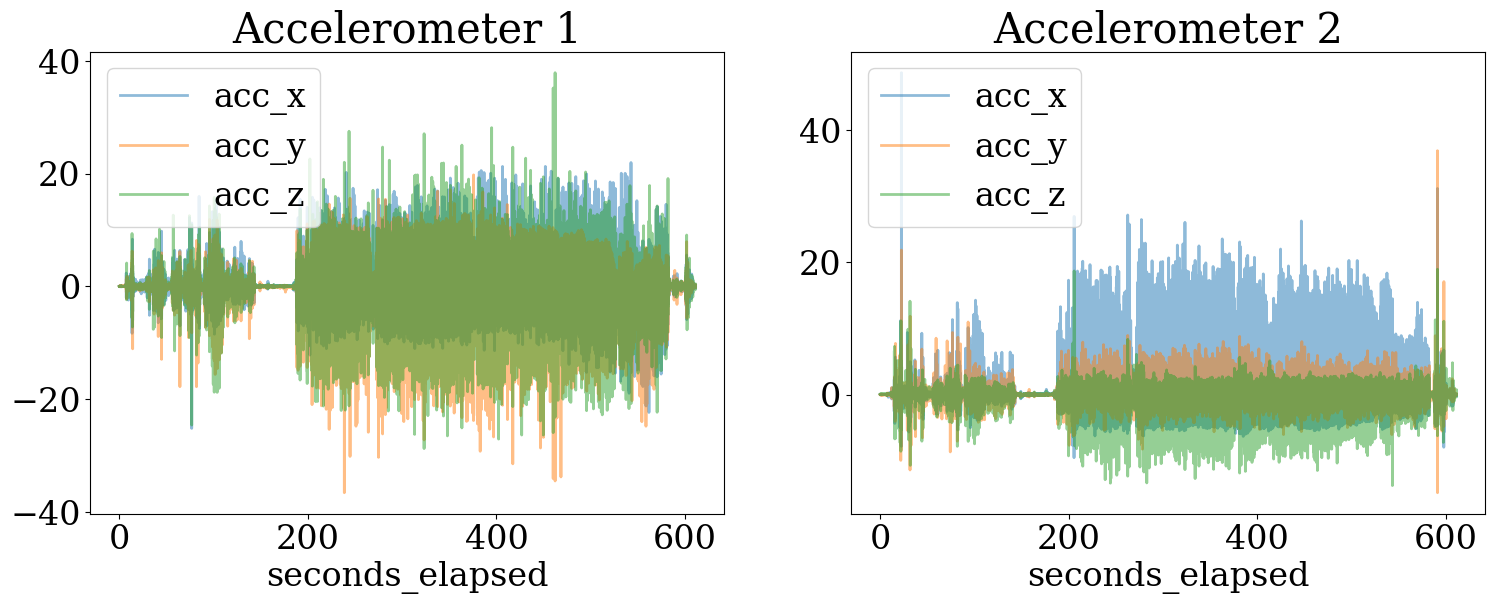

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

acc_1_df.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 1', ax=axes[0])
acc_2_df.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 2', ax=axes[1])
plt.show()

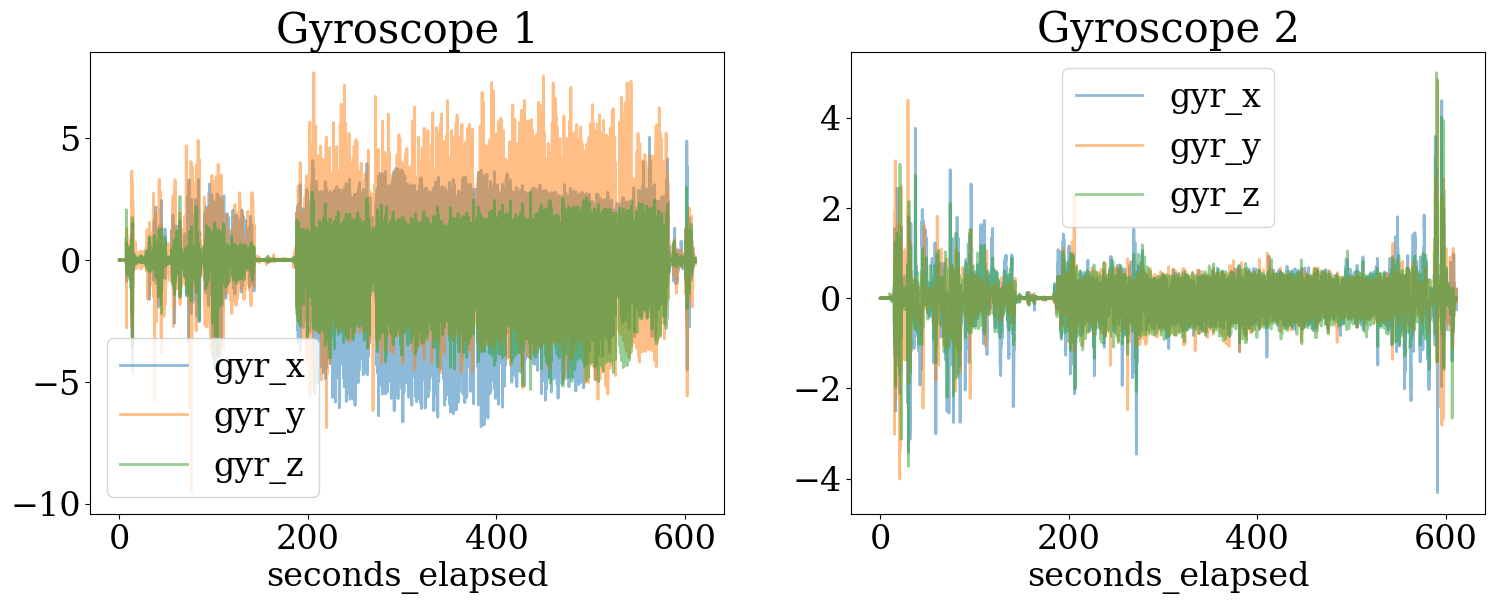

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

gyr_1_df.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 1', ax=axes[0])
gyr_2_df.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 2', ax=axes[1])
plt.show()

Join data from the same system

Note that tolerance is different because system 1 has a 60 Hz frequency while the system 2 has a 100 Hz frequency

0.017 $\approx 1/60$ 

In [9]:
eps = 1e3

df_1 = pd.merge_asof(acc_1_df, gyr_1_df, on='seconds_elapsed', direction='nearest', tolerance=1/60 + eps)
df_2 = pd.merge_asof(acc_2_df, gyr_2_df, on='seconds_elapsed', direction='nearest', tolerance=1/100 + eps)

In [10]:
assert len(df_1) == len(acc_1_df)
assert len(df_2) == len(acc_2_df)

In [11]:
print(df_1.shape)
df_1.head()

(38122, 9)


,time_x,seconds_elapsed,acc_z,acc_y,acc_x,time_y,gyr_z,gyr_y,gyr_x
0,1747571324974342100,0.078342,-0.012631,-0.002333,0.001062,1747571324967048400,0.001222,-0.003054,-0.001222
1,1747571324990302500,0.094302,-0.036629,-0.025879,-0.015898,1747571324982368300,0.000611,-0.001222,-0.001222
2,1747571325006293500,0.110293,0.025593,0.012618,-0.037439,1747571324998359000,-0.002443,-0.000611,-0.001833
3,1747571325022253800,0.126254,-0.065401,0.003188,0.009917,1747571325014319600,0.001222,-0.003665,0.000611
4,1747571325038244900,0.142245,-0.017526,0.008071,-0.009710,1747571325030310400,0.001222,-0.004276,0.000000


In [12]:
print(df_2.shape)
df_2.head()

(60952, 9)


,time_x,seconds_elapsed,acc_z,acc_y,acc_x,time_y,gyr_z,gyr_y,gyr_x
0,1747571324508624600,0.121625,0.062182,-0.000405,0.008137,1747571324508655000,-0.000533,0.001598,0.0
1,1747571324518604000,0.131604,0.057374,0.013954,0.001110,1747571324518634500,-0.000533,0.001598,0.0
2,1747571324528583200,0.141583,0.047779,0.016342,0.008448,1747571324528644000,-0.000533,0.001598,0.0
3,1747571324538562300,0.151562,0.047760,0.009153,-0.005762,1747571324538593000,-0.000533,0.001598,0.0
4,1747571324548541700,0.161542,0.062106,0.011541,0.011153,1747571324548602600,-0.000533,0.001598,0.0


In [13]:
df_1.drop(columns=['time_x', 'time_y'], inplace=True)
df_2.drop(columns=['time_x', 'time_y'], inplace=True)

Cut the data by time: drop first and last minute

In [14]:
min_t = 200
max_t = min(df_1.seconds_elapsed.max(), df_2.seconds_elapsed.max()) - 60

df_1 = df_1.query(f"{min_t} <= seconds_elapsed <= {max_t}").reset_index(drop=True)
df_2 = df_2.query(f"{min_t} <= seconds_elapsed <= {max_t}").reset_index(drop=True)

Align frequencies

In [15]:
df_merged = pd.concat(
    (df_1.assign(source=1), df_2.assign(source=2)),
    axis=0
)\
.reset_index(drop=True)\
.sort_values(by='seconds_elapsed', ignore_index=True)

df_merged.iloc[df_merged.query("source == 1").index, 1:-1] = None
df_merged = df_merged.set_index('seconds_elapsed')

In [16]:
df_interpolated = df_merged.interpolate(method='index')
df_2_interp = df_interpolated.query("source == 1").drop(columns='source').reset_index()

In [17]:
assert df_1.shape == df_2_interp.shape

### Vizualization

2D

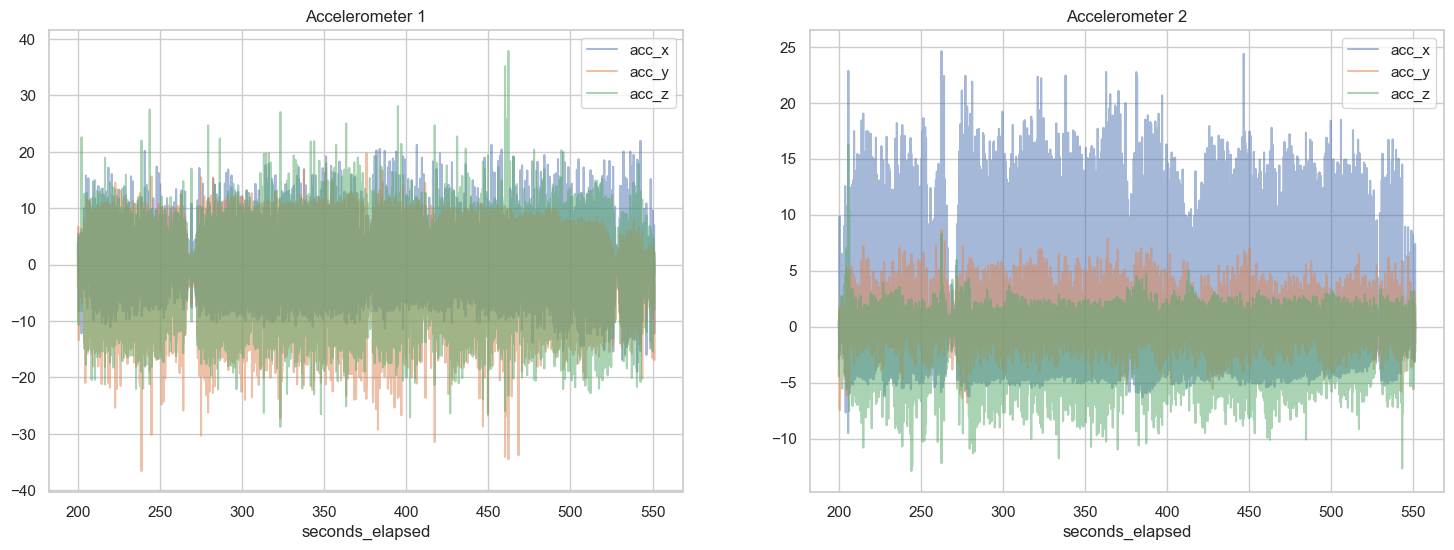

In [198]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

df_1.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 1', ax=axes[0])
df_2_interp.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 2', ax=axes[1])
plt.show()

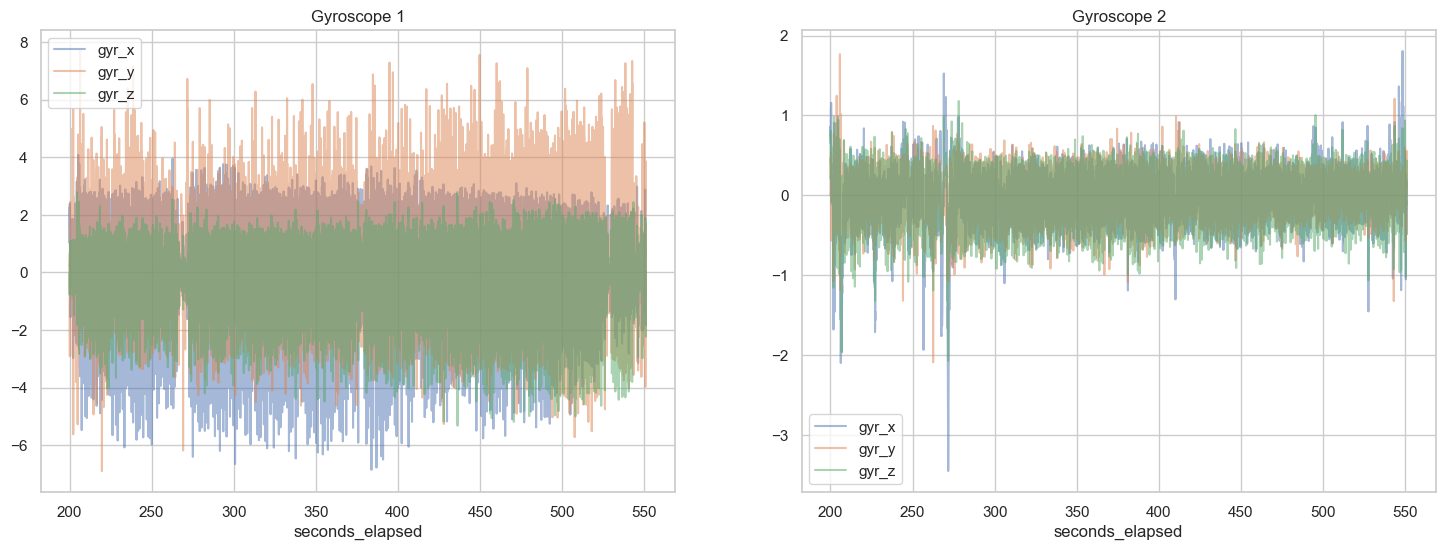

In [199]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

df_1.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 1', ax=axes[0])
df_2_interp.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 2', ax=axes[1])
plt.show()

3D

Plot function

In [370]:
def plot_imu_phase_trajectory(acc_data: np.ndarray, gyro_data: np.ndarray, alpha: float = 0.4, scatter: bool = False):
    if acc_data.shape[1] != 3 or gyro_data.shape[1] != 3:
        raise ValueError("Each input must have shape (N, 3).")

    N_acc = acc_data.shape[0]
    N_gyro = gyro_data.shape[0]
    if N_acc != N_gyro:
        print("Warning: Accelerometer and gyroscope have different lengths.")
    N = min(N_acc, N_gyro)

    # Truncate to the same length if needed
    acc = acc_data[:N, :]
    gyro = gyro_data[:N, :]

    fig = plt.figure(figsize=(12, 5))

    # Accelerometer 3D trajectory
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    if scatter:
        ax1.scatter(
            acc[:, 0],
            acc[:, 1],
            acc[:, 2],
            color="blue",
            linewidth=1.0,
            alpha=alpha
        )
    else:
        ax1.plot(
            acc[:, 0],
            acc[:, 1],
            acc[:, 2],
            color="blue",
            linewidth=1.0,
            alpha=alpha
        )
    ax1.set_xlabel('Accel X (m/s²)')
    ax1.set_ylabel('Accel Y (m/s²)')
    ax1.set_zlabel('Accel Z (m/s²)')
    ax1.set_title('Accelerometer 3D Phase Trajectory')

    # Gyroscope 3D trajectory
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    if scatter:
        ax2.scatter(
            gyro[:, 0],
            gyro[:, 1],
            gyro[:, 2],
            color="blue",
            linewidth=1.0,
            alpha=alpha
        )
    else:
        ax2.plot(
            gyro[:, 0],
            gyro[:, 1],
            gyro[:, 2],
            color="blue",
            linewidth=1.0,
            alpha=alpha
        )
    ax2.set_xlabel('Gyro X (rad/s)')
    ax2.set_ylabel('Gyro Y (rad/s)')
    ax2.set_zlabel('Gyro Z (rad/s)')
    ax2.set_title('Gyroscope 3D Phase Trajectory')

    # ax1.view_init(elev=30, azim=45)
    # ax2.view_init(elev=20, azim=70)

    plt.tight_layout()
    plt.show()

Time series smoothing functions

In [371]:
def moving_average(data: np.ndarray, window_size: int) -> np.ndarray:
    filtered = np.zeros_like(data)
    cumsum = np.cumsum(data, axis=0)
    
    # For i from 0 to N-1, sum over last window_size samples:
    #   sum_i = cumsum[i] - cumsum[i - window_size], taking care of i < window_size
    for i in range(data.shape[0]):
        start_idx = max(0, i - window_size + 1)
        if start_idx == 0:
            window_sum = cumsum[i]
            count = i + 1
        else:
            window_sum = cumsum[i] - cumsum[start_idx - 1]
            count = window_size
        filtered[i] = window_sum / count
    return filtered


def savgol_smooth(data: np.ndarray, window_size: int, polyorder: int = 3) -> np.ndarray:
    if window_size % 2 == 0:
        raise ValueError("window_length must be odd")
    if polyorder >= window_size:
        raise ValueError("polyorder must be < window_length")
    
    # Apply the filter axis by axis
    filtered = np.zeros_like(data)
    for axis in range(data.shape[1]):  # axis=0,1,2
        filtered[:, axis] = savgol_filter(
            data[:, axis],
            window_length=window_size,
            polyorder=polyorder,
            mode='interp'  # or 'mirror' to reduce end‐effects
        )
    return filtered


def butter_lowpass_filter(data: np.ndarray, cutoff: float = 5, fs: float = 60, order: int = 4) -> np.ndarray:
    # Normalize cutoff frequency: digital frequency = cutoff / (fs/2)
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    
    # Get IIR filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply filter with zero phase distortion via filtfilt
    filtered = np.zeros_like(data)
    for axis in range(data.shape[1]):
        filtered[:, axis] = filtfilt(b, a, data[:, axis])
    return filtered

Plot device 1

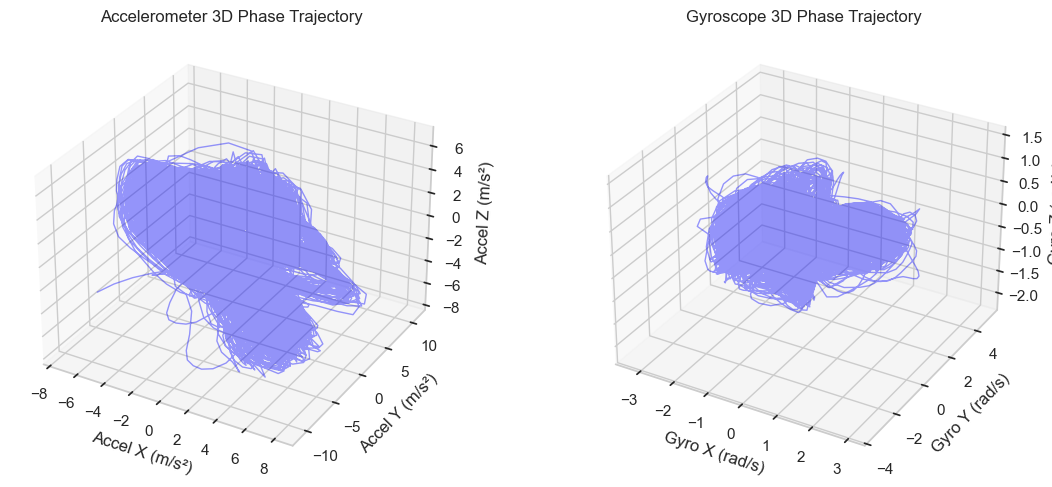

In [372]:
acc_1 = df_1[list(acc_columns_mapping.values())].values
gyr_1 = df_1[list(gyr_columns_mapping.values())].values

window = 21
acc_smoothed = savgol_smooth(acc_1, window_size=window)
gyro_smoothed = savgol_smooth(gyr_1, window_size=window)
# acc_smoothed = butter_lowpass_filter(acc_1)
# gyro_smoothed = butter_lowpass_filter(gyr_1)

plot_imu_phase_trajectory(acc_smoothed, gyro_smoothed, scatter=False, alpha=0.4)

Plot device 2

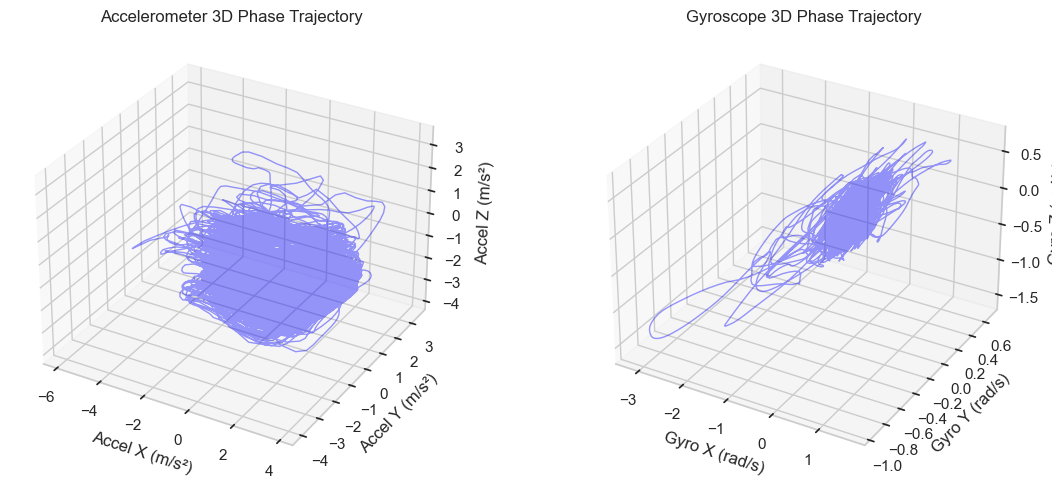

In [373]:
acc_2 = df_2_interp[list(acc_columns_mapping.values())].values
gyr_2 = df_2_interp[list(gyr_columns_mapping.values())].values

window = 21
acc_smoothed_2 = moving_average(acc_2, window_size=window)
gyro_smoothed_2 = moving_average(gyr_2, window_size=window)
# acc_smoothed_2 = butter_lowpass_filter(acc_2)
# gyro_smoothed_2 = butter_lowpass_filter(gyr_2)

plot_imu_phase_trajectory(acc_smoothed_2, gyro_smoothed_2, scatter=False, alpha=0.4)

Apply ICA

In [374]:
acc_1_ica = FastICA(n_components=3, random_state=SEED).fit_transform(acc_1)
gyr_1_ica = FastICA(n_components=3, random_state=SEED).fit_transform(gyr_1)

# acc_1_ica_v1 = np.lib.stride_tricks.sliding_window_view(acc_1_ica[..., 0], 3)
acc_1_ica_v2 = np.lib.stride_tricks.sliding_window_view(acc_1_ica[..., 1], 3)
# acc_1_ica_v3 = np.lib.stride_tricks.sliding_window_view(acc_1_ica[..., 2], 3)

# gyr_1_ica_v1 = np.lib.stride_tricks.sliding_window_view(gyr_1_ica[..., 0], 3)
# gyr_1_ica_v2 = np.lib.stride_tricks.sliding_window_view(gyr_1_ica[..., 1], 3)
gyr_1_ica_v3 = np.lib.stride_tricks.sliding_window_view(gyr_1_ica[..., 2], 3)

Plot ICA data for device 1

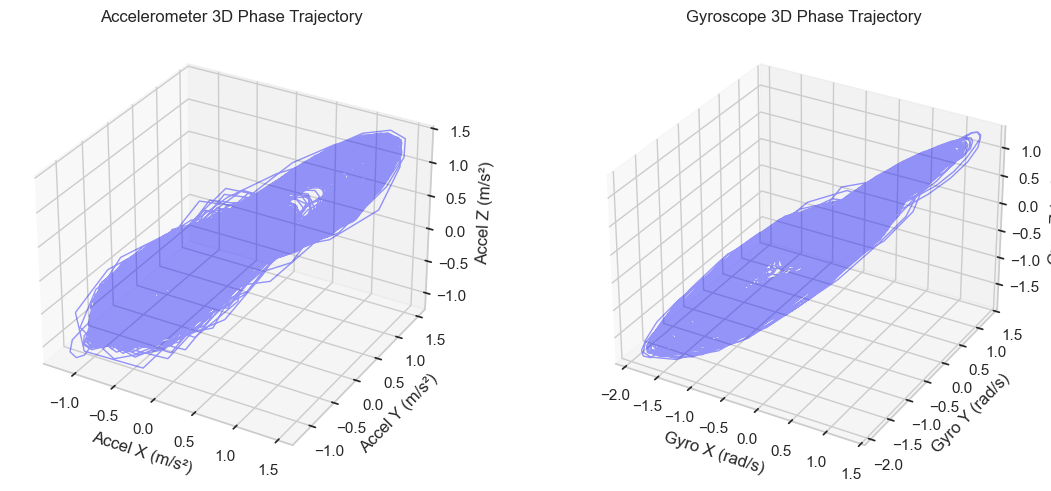

In [396]:
window = 12

plot_imu_phase_trajectory(
    moving_average(acc_1_ica_v2, window),
    moving_average(gyr_1_ica_v3, window),
    scatter=False,
    alpha=0.4
)

## Lagged-CCA

In [22]:
def _deflate(X, Z, w, method):
    """Return X with the rank‑1 influence of score Z removed via weight w."""
    if method == 'projection':
        return X - np.outer(Z, w) / (w @ w)
    if method == 'partial':          # column‑wise regression
        beta = (Z @ X) / (Z @ Z)     # shape (n_features,)
        return X - np.outer(Z, beta)
    raise ValueError("method must be 'projection', 'partial', or 'gram_schmidt'")


# --------------------------------------------------
# τ₋max CCA for **one** component
# --------------------------------------------------

def tau_max_cca_one(X, Y, lag_set, orth_method='projection'):
    """Return best‑lag CCA weights + deflated residuals (centering handled outside)."""
    T, p = X.shape
    _, q = Y.shape
    best_rho, best_tau, best_cca = -1, None, None

    for tau in lag_set:
        X_tau = X[:T - tau] if tau else X
        Y_tau = Y[tau:] if tau else Y
        cca   = CCA(n_components=1, scale=True)
        U, V  = cca.fit_transform(X_tau, Y_tau)
        rho   = np.corrcoef(U[:,0], V[:,0])[0,1]
        if rho > best_rho:
            best_rho, best_tau, best_cca = rho, tau, cca

    # scores on **aligned** slices
    X_tau = X[:T-best_tau] if best_tau else X
    Y_tau = Y[best_tau:]   if best_tau else Y
    Zc = X_tau @ best_cca.x_weights_[:,0]
    Wc = Y_tau @ best_cca.y_weights_[:,0]

    # Extend scores to full length by padding zeros (so shapes match X)
    if best_tau:
        Z_full = np.concatenate([Zc, np.zeros(best_tau)])
        W_full = np.concatenate([np.zeros(best_tau), Wc])
    else:
        Z_full, W_full = Zc, Wc

    X_perp = _deflate(X, Z_full, best_cca.x_weights_[:,0], orth_method)
    Y_perp = _deflate(Y, W_full, best_cca.y_weights_[:,0], orth_method)

    # re‑center residuals to keep mean‑zero property
    X_perp -= X_perp.mean(axis=0)
    Y_perp -= Y_perp.mean(axis=0)

    return {
        'tau_star': best_tau,
        'corr_max': best_rho,
        'a_star':   best_cca.x_weights_[:,0],
        'b_star':   best_cca.y_weights_[:,0],
        'Z_c':      Z_full,
        'W_c':      W_full,
        'X_perp':   X_perp,
        'Y_perp':   Y_perp
    }

# --------------------------------------------------
# Multi‑component extraction
# --------------------------------------------------

def multi_tau_max_cca(X, Y, lag_set, k_components=3, rho_threshold=0.1, orth_method='projection'):
    """Iteratively extract up to k_components causal coordinates."""
    X_res = X - X.mean(axis=0)
    Y_res = Y - Y.mean(axis=0)
    lag_set = set(lag_set)
    
    out = []
    for _ in tqdm.tqdm(range(k_components)):
        comp = tau_max_cca_one(X_res, Y_res, lag_set, orth_method)
        if comp['corr_max'] < rho_threshold:
            break
        out.append(comp)
        X_res, Y_res = comp['X_perp'], comp['Y_perp']
        lag_set.remove(comp['tau_star'])

    # stack results into convenient arrays
    if not out:
        raise RuntimeError('No component exceeded rho_threshold.')

    stacked = {
        'tau_star': np.array([c['tau_star'] for c in out]),
        'corr_max': np.array([c['corr_max'] for c in out]),
        'a_star':   np.stack([c['a_star']   for c in out]),
        'b_star':   np.stack([c['b_star']   for c in out]),
        'Z_c':      np.stack([c['Z_c']      for c in out]),
        'W_c':      np.stack([c['W_c']      for c in out]),
        'X_perp':   np.stack([c['X_perp']   for c in out]),
        'Y_perp':   np.stack([c['Y_perp']   for c in out])
    }
    return stacked


In [132]:
df_x = df_1.iloc[..., 1:]
df_y = df_2_interp.iloc[..., 1:]

cca_on_shifts = multi_tau_max_cca(
    df_x,
    df_y,
    np.arange(0, 20, 2),
    k_components=6,
    rho_threshold=0.1,
    orth_method='projection',
)

  0%|          | 0/6 [00:00<?, ?it/s]

### Check the method on synthetic data

In [24]:
def synthetic_lagged_series(T=1000, p=6, lag1=1, lag2=5, seed=42):
    """
    Generate two 6‑dimensional synthetic time series (X_t, Y_t).
    Y_t is driven by X_{t-lag1} and X_{t-lag2}.

    Parameters
    ----------
    T      : int  – length of the time series
    p      : int  – dimensionality (fixed to 6)
    lag1   : int  – leading lag #1 (positive means X precedes Y)
    lag2   : int  – leading lag #2
    seed   : int  – RNG seed

    Returns
    -------
    DataFrame with columns
        ['t', X0..X5, Y0..Y5]
    """
    rng = np.random.default_rng(seed)
    # base white noise for X
    X = rng.standard_normal((T + lag2, p))
    # coefficients for how X influences Y
    B1 = rng.normal(0.8, 0.1, (p, p))
    
    B2 = rng.normal(0.5, 0.1, (p, p))
    
    # own noise for Y
    noise_Y = rng.standard_normal((T + lag2, p)) * 0.5

    Y = np.zeros_like(X)
    # generate Y with specified lags
    for t in range(max(lag1, lag2), T + lag2):
        Y[t] = (X[t - lag1] @ B1 + X[t - lag2] @ B2 + noise_Y[t])

    # drop first lag2 samples to align
    X = X[lag2:]
    Y = Y[lag2:]
    time = np.arange(T)

    df = pd.DataFrame(
        np.hstack([time[:, None], X, Y]),
        columns=['t'] + [f'X{i}' for i in range(p)] + [f'Y{i}' for i in range(p)]
    )
    return df

# Example usage:
df_synth = synthetic_lagged_series(T=1000)
df_synth.head()


,t,X0,X1,X2,X3,X4,X5,Y0,Y1,Y2,Y3,Y4,Y5
0,0.0,2.141648,-0.406415,-0.512243,-0.813773,0.615979,1.128972,-0.187705,-1.176745,-0.142076,-0.224566,-1.005049,-1.488855
1,1.0,-0.113947,-0.840156,-0.824481,0.650593,0.743254,0.543154,2.145162,3.035175,3.171649,2.244060,2.857624,1.946823
2,2.0,-0.665510,0.232161,0.116686,0.218689,0.871429,0.223596,1.055082,0.164750,-0.328143,-0.724312,-0.917939,1.166161
3,3.0,0.678914,0.067579,0.289119,0.631288,-1.457156,-0.319671,1.043697,0.872074,0.362203,0.970346,2.091004,2.631703
4,4.0,-0.470373,-0.638878,-0.275142,1.494941,-0.865831,0.968278,-0.306063,-0.043931,0.078016,1.046508,0.525784,-0.014677


In [25]:
test_x = df_synth.loc[..., ['X0', 'X1', 'X2', 'X3',	'X4', 'X5']].values
test_y = df_synth.loc[..., ['Y0', 'Y1', 'Y2', 'Y3',	'Y4', 'Y5']].values

test_cca_on_shifts = multi_tau_max_cca(
    test_x,
    test_y,
    np.arange(10),
    k_components=6,
    rho_threshold=0.1,
    orth_method='projection',
)

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
test_cca_on_shifts['tau_star'], test_cca_on_shifts['corr_max']

(array([1, 5, 3, 0, 8, 6]),
 array([0.89880669, 0.54680945, 0.15749701, 0.1484697 , 0.12827277,
        0.1269879 ]))

## CCA-based causal embedding

In [398]:
class PureCCA:
    """
    Pure CCA pipeline as a scikit-learn style transformer.

    Parameters
    ----------
    lag_set : sequence of int
        Candidate lags to scan for causal delay.
    d_c : int
        Number of causal dimensions.
    d_hid : int
        Total hidden dimensionality (causal + reconstructive).
    """
    def __init__(self, lag_set, d_c=1, d_hid=3):
        assert d_c <= d_hid, "Causal dim should be <= hidden dim."
        self.lag_set = lag_set
        self.d_c = d_c
        self.d_hid = d_hid
        self.cca_ = None
        self.pca_x_ = None
        self.pca_y_ = None
        self.tau_star_ = None

    def _get_lags(self, X, Y):
        T = len(X)
        X_tau = X[:T - self.tau_star_] if self.tau_star_ else X
        Y_tau = Y[self.tau_star_:] if self.tau_star_ else Y
        return X_tau, Y_tau
        
    def _scan_lagged_cca(
        self, X: np.ndarray, Y: np.ndarray
    ):
        """Return τ⋆ and its first canonical correlation."""
        best_tau, best_rho = None, -np.inf
        T = len(X)
        for tau in self.lag_set:
            Xτ = X[:T - tau] if tau else X
            Yτ = Y[tau:] if tau else Y
            cca = CCA(n_components=1, scale=True)
            u, v = cca.fit_transform(Xτ, Yτ)
            rho = np.corrcoef(u[:, 0], v[:, 0])[0, 1]
            if rho > best_rho:
                best_tau, best_rho = tau, rho

        self.tau_star_ = best_tau

    def _deflate(self, Xc, Yc, cca_proj_x, cca_proj_y, return_padded=False):
        Zc = np.pad(cca_proj_x, ((0, self.tau_star_), (0, 0)), mode="edge")
        Wc = np.pad(cca_proj_y, ((self.tau_star_, 0), (0, 0)), mode="edge")
        
        X_res = Xc - Zc @ self.cca_.x_weights_.T
        Y_res = Yc - Wc @ self.cca_.y_weights_.T

        if return_padded:
            return X_res, Y_res, Zc, Wc
        else:
            return X_res, Y_res
    
    def fit(self, X, Y):
        # center
        T = len(X)
        Xc = X - X.mean(axis=0)
        Yc = Y - Y.mean(axis=0)
        
        # scan lag
        self._scan_lagged_cca(X, Y)
                
        # fit CCA causal block
        X_tau, Y_tau = self._get_lags(Xc, Yc)
        self.cca_ = CCA(n_components=self.d_c, scale=True)
        U, V = self.cca_.fit_transform(X_tau, Y_tau)

        # deflate
        X_res, Y_res = self._deflate(Xc, Yc, U, V)
        
        # reconstruction PCA
        d_res = self.d_hid - self.d_c
        self.pca_x_ = PCA(n_components=d_res)
        self.pca_y_ = PCA(n_components=d_res)
        self.pca_x_.fit(X_res)
        self.pca_y_.fit(Y_res)
        
        return self

    def transform(self, X, Y, split=False):
        """
        Transform new data into [causal, reconstructive] latents.

        Parameters
        ----------
        X, Y : array-like, shape (T, n_x), (T, n_y)
        split : bool
            If True, return Z_c, Z_r, W_c, W_r; else concatenate Z and reconstructive.
        """
        Xc = X - X.mean(axis=0)
        Yc = Y - Y.mean(axis=0)
        T, _ = Xc.shape
        
        # lagged
        X_tau, Y_tau = self._get_lags(Xc, Yc)
        U, V = self.cca_.transform(X_tau, Y_tau)
        
        # deflate
        X_res, Y_res, Zc, Wc = self._deflate(Xc, Yc, U, V, return_padded=True)
        
        Zr = self.pca_x_.transform(X_res)
        Wr = self.pca_y_.transform(Y_res)
        
        if split:
            return Zc, Zr, Wc, Wr
        else:
            return np.hstack([Zc, Zr]), np.hstack([Wc, Wr])

    def fit_transform(self, X, Y, split=False):
        self.fit(X, Y)
        return self.transform(X, Y, split)

    def reconstruct_x(self, X: np.ndarray) -> np.ndarray:
        """
        Given a fitted PureCCA model and original X, reconstruct X from latents:
           X_hat = mean(X) + Z_c @ A_c^T + Z_r @ PCA.components_
        """
        Xc = X - X.mean(axis=0)
        T, _ = Xc.shape
        tau = self.tau_star_
        X_tau = Xc[:T - tau] if tau else Xc
        
        U_c, _ = self.cca_.transform(X_tau, X_tau)
        Zc = np.pad(U_c, ((0, tau), (0, 0)), mode="edge")
        X_res = Xc - Zc @ self.cca_.x_weights_.T
        Zr = self.pca_x_.transform(X_res)
        Xc_hat = Zc @ self.cca_.x_weights_.T + Zr @ self.pca_x_.components_
        X_hat = Xc_hat + X.mean(axis=0)
        return X_hat

    def reconstruct_y(self, Y: np.ndarray) -> np.ndarray:
        """
        Reconstruct Y analogous to X reconstruction.
        """
        Yc = Y - Y.mean(axis=0)
        T, _ = Yc.shape
        tau = self.tau_star_
        Y_tau = Yc[:T - tau] if tau else Xc
        
        _, V_c = self.cca_.transform(Y_tau, Y_tau)
        Wc = np.pad(V_c, ((tau, 0), (0, 0)), mode="edge")
        Y_res = Yc - Wc @ self.cca_.y_weights_.T
        Wr = self.pca_y_.transform(Y_res)
        Yc_hat = Wc @ self.cca_.y_weights_.T + Wr @ self.pca_y_.components_
        Y_hat = Yc_hat + Y.mean(axis=0)
        return Y_hat

In [399]:
df_x = df_1.iloc[..., 1:].values
df_y = df_2_interp.iloc[..., 1:].values

pure_cca = PureCCA(lag_set=np.arange(10), d_c=2, d_hid=4)
pure_cca.fit(df_x, df_y)

x_hidden, y_hidden = pure_cca.transform(df_x, df_y)
x_causal, x_resid, y_causal, y_resid = pure_cca.transform(df_x, df_y, split=True)

In [400]:
assert len(df_x) == len(x_recov)
assert len(df_y) == len(y_recov)
assert len(x_recov) == len(y_recov)

## Quality criterions

### Multicolinearity diagnostics

Condition number of $Z^T Z$ and Variance Inflation Factor (VIF)

VIF, cond.number: lower -- better

In [401]:
def compute_vif(X: np.ndarray) -> pd.DataFrame:
    """
    Compute Variance Inflation Factor (VIF) for each feature in X.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data matrix (e.g., latent space representation).
    
    Returns
    -------
    vif_df : pandas DataFrame
        DataFrame with columns ['feature', 'VIF'].
    """
    n_samples, n_features = X.shape
    vif_values = []
    for j in range(n_features):
        # Define feature j as target, others as predictors
        X_j = X[:, j]
        X_others = np.delete(X, j, axis=1)
        
        # Fit linear regression of X_j on X_others
        model = LinearRegression().fit(X_others, X_j)
        r2_j = model.score(X_others, X_j)
        vif_j = 1.0 / (1.0 - r2_j) if r2_j < 1.0 else np.inf
        vif_values.append(vif_j)

    return max(vif_values)

def compute_cond_number(X: np.ndarray) -> float:
    """
    Compute the condition number of X^T X.
    
    Parameters
    ----------
    X : ndarray of shape (n_samples, n_features)
        Input data matrix.
    
    Returns
    -------
    cond_number : float
        Condition number (ratio of largest to smallest singular value).
    """
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    cond_number = np.log(s.max() / s.min())
    return cond_number

In [402]:
vif_x, vif_y = compute_vif(df_x), compute_vif(df_y)
vif_zx, vif_zy = compute_vif(x_hidden), compute_vif(y_hidden)

print("VIF of the original data:", round(vif_x, 2), round(vif_y, 2))
print("VIF of the latent data:", round(vif_zx, 2), round(vif_zy, 2))

VIF of the original data: 1.63 1.51
VIF of the latent data: 2.06 18.3


In [403]:
cond_x, cond_y = compute_cond_number(df_x), compute_cond_number(df_y)
cond_zx, cond_zy = compute_cond_number(x_hidden), compute_cond_number(y_hidden)

print("Log cond.number of the original data:", round(cond_x, 2), round(cond_y, 2))
print("Log cond.number of the latent data:", round(cond_zx, 2), round(cond_zy, 2))

Log cond.number of the original data: 2.13 3.16
Log cond.number of the latent data: 2.18 3.18


### Reconstruction error

In [404]:
def compute_rmse(X_true: np.ndarray, X_pred: np.ndarray) -> float:
    """
    Compute Root Mean Squared Error between X_true and X_pred.
    """
    return np.sqrt(np.mean((X_true - X_pred) ** 2))


def compute_explained_variance(X_true: np.ndarray, X_pred: np.ndarray) -> float:
    """
    Compute the fraction of variance in X_true explained by X_pred.
    """
    var_true = np.var(X_true, axis=0).sum()
    var_resid = np.var(X_true - X_pred, axis=0).sum()
    return 1 - (var_resid / var_true)

In [405]:
recon_x, recon_y = pure_cca.reconstruct_x(df_x), pure_cca.reconstruct_y(df_y)

rmse_x, rmse_y = compute_rmse(df_x, recon_x), compute_rmse(df_y, recon_y)
expl_var_x, expl_var_y = compute_explained_variance(df_x, recon_x), compute_explained_variance(df_y, recon_y)

print("RMSE of the reconstruction:", round(rmse_x, 2), round(rmse_y, 2))
print("Explained variance ratio:", round(expl_var_x, 2), round(expl_var_y, 2))

RMSE of the reconstruction: 1.6 0.7
Explained variance ratio: 0.83 0.89


### Predictive performance

In [406]:
class DataMode(IntEnum):
    AR_ONLY = 1
    AR_LATENT = 2
    AR_ALL = 3


def build_lagged_features(
        Y: np.ndarray, 
        X: np.ndarray = None, 
        Zc: np.ndarray = None,
        p: int = 1, 
        q: int = 0, 
        mode: DataMode = DataMode.AR_ONLY
) -> (np.ndarray, np.ndarray):
    """
    Build lagged feature matrix and targets for multivariate time series prediction.
    
    Parameters
    ----------
    Y : ndarray, shape (T, n_y)
        Target time series to predict.
    X : ndarray, shape (T, n_x), optional
        Original feature time series for exogenous variables (if use_latent=False).
    Zc : ndarray, shape (T, d_c), optional
        Causal latent series for exogenous features (if use_latent=True).
    p : int
        Number of autoregressive lags for Y.
    q : int
        Number of exogenous lags (for X or Zc).
    mode : DataMode
        TOFILL.
    
    Returns
    -------
    X_feat : ndarray, shape (N_samples, n_features)
        Lagged feature matrix.
    Y_target : ndarray, shape (N_samples, n_y)
        Targets aligned with feature matrix.
    """
    T, n_y = Y.shape
    max_lag = max(p, q)
    rows = T - max_lag
    
    # Prepare Y lagged features
    # For each t from max_lag to T-1, features are Y[t-1], Y[t-2], ..., Y[t-p]
    Y_lags = []
    for i in range(1, p + 1):
        Y_lags.append(Y[max_lag - i : T - i, :])
    if Y_lags:
        Y_lagged = np.hstack(Y_lags)  # shape (rows, n_y * p)
    else:
        Y_lagged = np.empty((rows, 0))
    
    # Prepare exogenous features
    if q > 0 and mode == DataMode.AR_LATENT:
        assert Zc is not None, "Zc must be provided when use_latent=True"
        Ex = []
        for j in range(1, q + 1):
            Ex.append(Zc[max_lag - j : T - j, :])
        X_exog = np.hstack(Ex)  # shape (rows, d_c * q)
    elif q > 0 and mode == DataMode.AR_ALL:
        assert X is not None, "X must be provided when use_latent=False"
        Ex = []
        for j in range(1, q + 1):
            Ex.append(X[max_lag - j : T - j, :])
        X_exog = np.hstack(Ex)  # shape (rows, n_x * q)
    elif mode == DataMode.AR_ONLY:
        X_exog = np.empty((rows, 0))
    
    # Concatenate AR and exogenous features
    if Y_lagged.size and X_exog.size:
        X_feat = np.hstack([Y_lagged, X_exog])
    elif Y_lagged.size:
        X_feat = Y_lagged
    elif X_exog.size:
        X_feat = X_exog
    else:
        raise ValueError("At least one of p>0 or q>0 must hold")
    
    # Targets: Y[max_lag:T]
    Y_target = Y[max_lag:, :]
    return X_feat, Y_target


def bic_from_residuals(residuals: np.ndarray, num_params: int) -> float:
    """
    Compute BIC for a linear regression given the array of residuals.

    Parameters
    ----------
    residuals : np.ndarray
        1D array of length n, the prediction errors y_i - y_i_hat.
    num_params : int
        Total number of free parameters in the model (e.g., p+1 if you have p predictors and an intercept).

    Returns
    -------
    float
        The Bayesian Information Criterion (BIC).
    """
    n = residuals.shape[0]
    
    # 1) Compute RSS = sum(e_i^2)
    rss = np.sum(residuals ** 2)

    # 2) Estimate sigma^2_hat = RSS / n
    sigma2_hat = rss / n

    # 3) Compute log-likelihood for Gaussian residuals
    #    ln(L_hat) = - (n/2) * [ln(2π * sigma2_hat) + 1]
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2_hat) + 1.0)

    # 4) Compute BIC:
    #    BIC = k * ln(n) - 2 * log_likelihood
    bic_value = num_params * np.log(n) - 2.0 * log_likelihood

    return bic_value


def update_metrics(metrics_dir, y_true, y_pred, **kwargs):
    k_params = kwargs.get('k_params', y_true.shape[1])
    residuals = y_true - y_pred
    
    acc_true, gyr_true = np.split(y_true, 2, axis=1)
    acc_pred, gyr_pred = np.split(y_pred, 2, axis=1)

    acc_magn_true = np.linalg.norm(acc_true, axis=1)
    gyr_magn_true = np.linalg.norm(gyr_true, axis=1)
    acc_magn_pred = np.linalg.norm(acc_pred, axis=1)
    gyr_magn_pred = np.linalg.norm(gyr_pred, axis=1)
    
    metrics_dir['rmse'].append(compute_rmse(y_true, y_pred))
    metrics_dir['magnitude_rmse'].append(
        compute_rmse(acc_magn_true, acc_magn_pred) + compute_rmse(gyr_magn_true, gyr_magn_pred)
    )
    metrics_dir['bic'].append(bic_from_residuals(residuals, k_params))
    metrics_dir['expl_var_ratio'].append(compute_explained_variance(y_true, y_pred))


| PureCCA Training (%) | Model Training (%) | Validation (%) |
| -------------------- | ------------------ | -------------- |
| 0-20                 | 0-30               | 30-40          |
| 0-30                 | 0-40               | 40-50          |
| 0-40                 | 0-50               | 50-60          |
| 0-50                 | 0-60               | 60-70          |
| 0-60                 | 0-70               | 70-80          |

In [426]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, train_size=0.8, shuffle=False)
splitter = TimeSeriesSplit(n_splits=5, test_size=int(0.125*len(X_train)))

# Experiment settings
LAG_SET = np.arange(10)
CAUSAL_DIM = 2
HIDDEN_DIM = 4
AR_LAGS = 5
EXOG_LAGS = 5

linreg_logs = dict()
METRICS = ['rmse', 'magnitude_rmse', 'bic', 'expl_var_ratio']

for data_mode in tqdm.tqdm(DataMode):
    metric_dict = dict()
    for metric_nm in METRICS:
        metric_dict[metric_nm] = list()
    
    for train_index, test_index in splitter.split(X_train):
        test_size = len(test_index)
        purecca_index = train_index[:-test_size]
    
        fold_cca = PureCCA(lag_set=LAG_SET, d_c=CAUSAL_DIM, d_hid=HIDDEN_DIM)
        fold_cca.fit(X_train[purecca_index], Y_train[purecca_index])
        X_c_train, _, _, _ = fold_cca.transform(X_train[train_index], np.zeros_like(Y_train[test_index]), split=True)
        X_c_val, _, _, _ = fold_cca.transform(X_train[test_index], np.zeros_like(Y_train[test_index]), split=True)

        # X_c_train = X_c_train[:-fold_cca.tau_star_] if fold_cca.tau_star_ > 0 else X_c_train
        # X_c_val = X_c_val[:-fold_cca.tau_star_] if fold_cca.tau_star_ > 0 else X_c_val

        # X_c_train = np.pad(X_c_train, ((0, fold_cca.tau_star_), (0, 0)), mode="edge")
        # X_c_val = np.pad(X_c_val, ((0, fold_cca.tau_star_), (0, 0)), mode="edge")
        
        data_train, target_train = build_lagged_features(
            Y=Y_train[train_index],
            X=X_train[train_index],
            Zc=X_c_train,
            p=AR_LAGS,
            q=EXOG_LAGS,
            mode=data_mode
        )
        data_val, target_val = build_lagged_features(
            Y=Y_train[test_index],
            X=X_train[test_index],
            Zc=X_c_val,
            p=AR_LAGS,
            q=EXOG_LAGS,
            mode=data_mode
        )

        linreg = Pipeline([
            ('scaler', StandardScaler()),
            ('linreg', ElasticNet(random_state=SEED))
        ])
    
        linreg.fit(data_train, target_train)
        target_pred = linreg.predict(data_val)
    
        update_metrics(metric_dict, target_val, target_pred, k_params=data_train.shape[1])

    linreg_logs[data_mode.name] = metric_dict

  0%|          | 0/3 [00:00<?, ?it/s]

In [427]:
metrics = [
    ('rmse', "{:.3f} ± {:.3f}"),
    ('magnitude_rmse', "{:.3f} ± {:.3f}"),
    ('bic', "{:.1f} ± {:.1f}"),
    ('expl_var_ratio', "{:.3f} ± {:.3f}")
]

# Build a table: rows = approaches, columns = metrics formatted as strings
rows = []
for approach, values_dict in linreg_logs.items():
    row = {'Approach': approach}
    for metric_name, fmt in metrics:
        vals = np.array(values_dict[metric_name])
        mean = np.mean(vals)
        std = np.std(vals)
        row[metric_name] = fmt.format(mean, std)
    rows.append(row)

df_summary = pd.DataFrame(rows)
df_summary = df_summary[['Approach', 'rmse', 'magnitude_rmse', 'bic', 'expl_var_ratio']]
df_summary.columns = ['Approach', 'RMSE', 'Magnitude RMSE', 'BIC', 'Explained Var.Ratio']

df_summary

,Approach,RMSE,Magnitude RMSE,BIC,Explained Var.Ratio
0,AR_ONLY,1.377 ± 0.059,3.335 ± 0.158,11739.0 ± 187.5,0.606 ± 0.010
1,AR_LATENT,1.336 ± 0.058,3.230 ± 0.151,11684.9 ± 191.4,0.629 ± 0.010
2,AR_ALL,1.310 ± 0.054,3.143 ± 0.135,11752.5 ± 180.1,0.644 ± 0.009


Create a separate function, loop over different p, q and regression models

In [492]:
LAG_SET = np.arange(10)
CAUSAL_DIM = 2
HIDDEN_DIM = 4

AR_GRID = np.arange(1, 8)
EXOG_GRID = np.arange(1, 8)
MODEL_GRID = ('linear', 'knn', 'boosting')

metrics_formatting = [
    ('rmse', "{:.3f} ± {:.3f}"),
    ('magnitude_rmse', "{:.3f} ± {:.3f}"),
    ('bic', "{:.1f} ± {:.1f}"),
    ('expl_var_ratio', "{:.3f} ± {:.3f}")
]
results = []

for model_nm in tqdm.tqdm(MODEL_GRID):
    for P in tqdm.tqdm(AR_GRID):
        for Q in EXOG_GRID:
            elem_result = test_all_modes(
                df_x,
                df_y,
                lag_set=LAG_SET,
                causal_dim=CAUSAL_DIM,
                hidden_dim=HIDDEN_DIM,
                ar_lags=P,
                exog_lags=Q,
                model_nm=model_nm
            )
            elem_df = pd.DataFrame(elem_result).T.reset_index()
            elem_df['model'] = model_nm
            elem_df['ar'] = P
            elem_df['exog'] = Q
            results.append(elem_df)

results_test_df = pd.concat(results, ignore_index=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [478]:
def instantiate_model(typo: str):
    if typo == "linear":
        return Pipeline([
            ('scaler', StandardScaler()),
            ('linreg', MultiTaskElasticNet(random_state=SEED))
        ])
    elif typo == "knn":
        return Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_jobs=4))
        ])
    elif typo == "boosting":
        return CatBoostRegressor(
            iterations=200,
            depth=6,
            learning_rate=0.05,
            verbose=False,
            loss_function='MultiRMSE',
            task_type='GPU',
        )
    else:
        raise ValueError("Wrong model name")


def cross_validate_all_modes(
    X: np.ndarray,
    Y: np.ndarray,
    lag_set: np.ndarray,
    causal_dim: int,
    hidden_dim: int,
    ar_lags: int,
    exog_lags: int,
    n_splits: int = 5,
    train_ratio: float = 0.8,
    val_size_frac: float = 0.125,
    seed: int = SEED,
    model_nm: str = 'linear',
    model_factory: Callable[[str], Any] = instantiate_model
) -> dict:
    """
    Runs PureCCA + AR‐based regression under each DataMode (AR_ONLY, AR_LATENT, AR_ALL),
    using TimeSeriesSplit to avoid data leakage. Returns a dict linreg_logs such that:

        logs["AR_ONLY"]["rmse"]           = [one rmse per fold]
        logs["AR_ONLY"]["magnitude_rmse"] = [one mag‐rmse per fold]
        logs["AR_ONLY"]["bic"]            = [one BIC per fold]
        logs["AR_ONLY"]["expl_var_ratio"] = [one explained‐variance per fold]

    Similarly for "AR_LATENT" and "AR_ALL".

    Parameters
    ----------
    X : (T, n_x) array of original features (e.g. 6‐dim IMU from tablet)
    Y : (T, n_y) array of target features (e.g. 6‐dim IMU from phone)
    lag_set : 1D array of candidate integer lags (e.g. np.arange(10))
    causal_dim : int, number of causal latents (d_c)
    hidden_dim : int, total latent dimension (d_hid ≥ d_c)
    ar_lags : int, number of autoregressive lags p for Y
    exog_lags : int, number of exogenous lags q for X or Zc
    n_splits : int, how many folds of TimeSeriesSplit on the 80% block
    test_size_frac : float, the fraction of the original data held out for "final test"
                     (default 0.125 = 10% of the 80% becomes 10% of full, i.e. final test = 20%).
    seed : int, random_state for ElasticNet

    Returns
    -------
    linreg_logs : dict
        Keys = ["AR_ONLY","AR_LATENT","AR_ALL"], each mapping to a dict of lists:
        { 'rmse': [...], 'magnitude_rmse': [...], 'bic': [...], 'expl_var_ratio': [...] }
        where each list has length = n_splits (the number of CV folds).
    """
    # (1) Split off final 20% for a held‐out test (we’ll do that after the CV)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio, shuffle=False)
    splitter = TimeSeriesSplit(n_splits=n_splits, test_size=int(val_size_frac*len(X_train)))

    # Prepare output structure
    quality_criterion_logs_cv = {
        mode.name: {
            'rmse':           [],
            'magnitude_rmse': [],
            'bic':            [],
            'expl_var_ratio': []
        }
        for mode in DataMode
    }

    # (3) Loop over each DataMode
    for mode in DataMode:
        for train_idx, val_idx in splitter.split(X_train):
            # (3a) Further split “train_idx” into:
            #      cca_train_idx = train_idx[ : (len(train_idx) - len(val_idx)) ]
            #      model_train_idx = train_idx
            test_size = len(val_idx)
            cca_train_idx = train_idx[:-test_size]

            # (3b) Fit PureCCA on [0 : cca_train_end]
            cca = PureCCA(lag_set=lag_set, d_c=causal_dim, d_hid=hidden_dim)
            cca.fit(
                X_train[cca_train_idx],
                Y_train[cca_train_idx]
            )

            # (3c) Transform “model_train” window → get Zc_train, Wc_train
            Zc_train, _, _, _ = cca.transform(
                X_train[train_idx],
                Y_train[train_idx],
                split=True
            )
            # (3d) Transform “model_val” window → get Zc_val, Wc_val
            Zc_val, _, _, _ = cca.transform(
                X_train[val_idx],
                Y_train[val_idx],
                split=True
            )

            # (3e) Build lagged features for the (train_idx) and (val_idx) portion
            X_feat_train, Y_target_train = build_lagged_features(
                Y=Y_train[train_idx],
                X=X_train[train_idx],
                Zc=Zc_train,
                p=ar_lags,
                q=exog_lags,
                mode=mode
            )
            X_feat_val, Y_target_val = build_lagged_features(
                Y=Y_train[val_idx],
                X=X_train[val_idx],
                Zc=Zc_val,
                p=ar_lags,
                q=exog_lags,
                mode=mode
            )

            # (3f) Re‐create a fresh ElasticNet pipeline inside each fold
            model = model_factory(model_nm)
            model.fit(X_feat_train, Y_target_train)
            Y_pred_val = model.predict(X_feat_val)

            update_metrics(
                quality_criterion_logs_cv[mode.name],
                Y_target_val,
                Y_pred_val,
                k_params=X_feat_train.shape[1]
            )

    return quality_criterion_logs_cv

In [484]:
def test_all_modes(
    X: np.ndarray,
    Y: np.ndarray,
    lag_set: np.ndarray,
    causal_dim: int,
    hidden_dim: int,
    ar_lags: int,
    exog_lags: int,
    n_splits: int = 5,
    train_ratio: float = 0.8,
    seed: int = SEED,
    model_nm: str = 'linear',
    model_factory: Callable[[str], Any] = instantiate_model
) -> dict:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio, shuffle=False)
    
    quality_criterion_logs_test = {
        mode.name: {
            'rmse':           [],
            'magnitude_rmse': [],
            'bic':            [],
            'expl_var_ratio': []
        }
        for mode in DataMode
    }

    for mode in DataMode:
        cca = PureCCA(lag_set=lag_set, d_c=causal_dim, d_hid=hidden_dim)
        cca.fit(X_train, Y_train)

        Zc_train, _, _, _ = cca.transform(X_train, Y_train, split=True)
        Zc_test, _, _, _ = cca.transform(X_test, Y_test, split=True)

        X_feat_train, Y_target_train = build_lagged_features(
            Y=Y_train,
            X=X_train,
            Zc=Zc_train,
            p=ar_lags,
            q=exog_lags,
            mode=mode
        )
        X_feat_test, Y_target_test = build_lagged_features(
            Y=Y_test,
            X=X_test,
            Zc=Zc_test,
            p=ar_lags,
            q=exog_lags,
            mode=mode
        )

        model = model_factory(model_nm)
        model.fit(X_feat_train, Y_target_train)
        Y_pred_test = model.predict(X_feat_test)

        update_metrics(
            quality_criterion_logs_test[mode.name],
            Y_target_test,
            Y_pred_test,
            k_params=X_feat_train.shape[1]
        )

    modified_res = {
        mode: {
            nm: val[0] for nm, val in metric_info.items()
        } for mode, metric_info in quality_criterion_logs_test.items()
    }
    return modified_res

In [494]:
results_test_df.reset_index(drop=True)

,index,rmse,magnitude_rmse,bic,expl_var_ratio,model,ar,exog
0,AR_ONLY,1.225810,3.032227,22111.668941,0.613576,linear,1,1
1,AR_LATENT,1.225810,3.032227,22128.438549,0.613576,linear,1,1
2,AR_ALL,1.198137,2.954410,21961.951908,0.630919,linear,1,1
3,AR_ONLY,1.225894,3.032501,22107.234449,0.613585,linear,1,2
4,AR_LATENT,1.225894,3.032501,22140.772752,0.613585,linear,1,2
...,...,...,...,...,...,...,...,...
436,AR_LATENT,0.475705,0.991466,14203.338973,0.941832,boosting,7,6
437,AR_ALL,0.452172,0.922543,13960.715828,0.947487,boosting,7,6
438,AR_ONLY,0.458299,0.936466,13776.643990,0.945929,boosting,7,7
439,AR_LATENT,0.482615,1.000792,14346.271977,0.940072,boosting,7,7


In [500]:
results_test_df.drop(columns=['ar', 'exog']).groupby(['model', 'index']).agg(['mean', 'std'])

rmse           magnitude_rmse                     bic  \
                        mean       std           mean       std          mean   
model    index                                                                  
boosting AR_ALL     0.469911  0.022431       0.958792  0.054064  14042.352163   
         AR_LATENT  0.496222  0.039953       1.031999  0.100390  14368.666053   
         AR_ONLY    0.473264  0.033661       0.971947  0.084850  13892.847379   
knn      AR_ALL     0.688242  0.026213       1.341463  0.050375  17385.001813   
         AR_LATENT  0.679039  0.023287       1.335606  0.053416  17134.266850   
         AR_ONLY    0.630605  0.042424       1.215596  0.089768  16405.308072   
linear   AR_ALL     1.137944  0.017968       2.761825  0.057369  21790.949238   
         AR_LATENT  1.174159  0.022661       2.857511  0.072114  21930.469563   
         AR_ONLY    1.191040  0.016879       2.893927  0.064270  21989.045933   

                               expl_var_ratio            
                           std           mean       std  
model    index                                           
boosting AR_ALL     359.495885       0.943060  0.005644  
         AR_LATENT  608.201616       0.936201  0.010902  
         AR_ONLY    524.987262       0.942025  0.008882  
knn      AR_ALL     396.560674       0.877361  0.009352  
         AR_LATENT  328.789826       0.880756  0.008204  
         AR_ONLY    670.378024       0.897344  0.013911  
linear   AR_ALL      67.091291       0.667577  0.010804  
         AR_LATENT   89.699250       0.645540  0.013818  
         AR_ONLY     47.429219       0.635274  0.010455

## CCA + MI + CCM